# 2) Event Study — PEAD

> Read me
- Run top-to-bottom. Uses simulated data only (numpy/pandas/matplotlib).
- Cells with **TODO** are what interviewers often expect you to implement.
- Keep runs fast. Vectorize when possible.
- Use clean functions with docstrings; add comments where you make assumptions.


## Setup & Data (simulated)

In [1]:
import numpy as np, pandas as pd
import matplotlib.pyplot as plt

np.random.seed(0)
n = 1200
tickers = [f"U{i:04d}" for i in range(n)]
days = pd.date_range("2016-01-01","2020-12-31",freq="B")

mkt = pd.Series(np.random.normal(0.0003, 0.01, len(days)), index=days)
beta = pd.Series(np.random.normal(1.0,0.2,n), index=tickers).clip(0.2,2)
mi = pd.MultiIndex.from_product([days, tickers], names=["date","ticker"])
ret = pd.DataFrame(index=mi, columns=["ret"], dtype=float)
ret["ret"] = (mkt.loc[ret.index.get_level_values(0)].values * beta.loc[ret.index.get_level_values(1)].values
              + np.random.normal(0,0.02,len(ret)))

qdates = pd.date_range("2016-01-01","2020-12-31",freq="Q")
events = []
for t in tickers:
    for d in qdates:
        if np.random.rand()<0.85:
            s = np.random.normal(0,1)
            events.append((d, t, s))
events = pd.DataFrame(events, columns=["date","ticker","surprise"])

# Inject drift starting T+1 for +20 business days
ret = ret.sort_index()
ret["ret_adj"] = ret["ret"].values
for _, r in events.iterrows():
    d, t, s = r["date"], r["ticker"], r["surprise"]
    window = pd.date_range(d, periods=22, freq="B")[1:]
    idx = pd.MultiIndex.from_product([window, [t]])
    idx = idx.intersection(ret.index)
    ret.loc[idx, "ret_adj"] += s * 0.0007


/var/folders/kc/7dyzg2fs2zv9v849s3n6rd4w0000gn/T/ipykernel_8824/1372382733.py:16: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  qdates = pd.date_range("2016-01-01","2020-12-31",freq="Q")


## TODO Checklist
1. Create **surprise deciles** (point-in-time, no lookahead).
2. Compute **abnormal returns** using a simple market model (AR = r - beta*mkt).
3. For each decile, compute **CAR** over **[-1, +20]** (align windows carefully).
4. Plot CAR for **top vs bottom decile**.
5. Robustness: **exclude bottom 20% ADV proxy** (simulate ADV by variance/price) and re-run.


In [8]:
# === TODO 1: Bucket by surprise deciles (no lookahead) ===
# events["decile"] = ...
events['decile'] = events.groupby('date')['surprise'].transform(lambda x : pd.qcut(x.rank(method='first'), q=10, labels=False))

In [77]:


# === TODO 2–4: Abnormal returns & CAR ===
def abnormal_returns(idx_window, ticker):
    # TODO: implement r - beta*mkt for the window
    beta_stock = beta.loc[ticker]
    ret_stock = ret.loc[pd.MultiIndex.from_product([idx_window, [ticker]]), 'ret_adj'].reset_index(level=1, drop=True)
    ret_mkt = mkt.loc[idx_window]
    ret_abn = ret_stock - beta_stock * ret_mkt
    return ret_abn.values
    


In [78]:
ticker = 'U0001'
window = ret.index.get_level_values(0).unique().sort_values()[100:122]
abnormal_returns(window, ticker)

array([-0.02525664, -0.00366371, -0.01350227, -0.01134989,  0.01284015,
       -0.03403905, -0.017818  ,  0.03311938,  0.0255069 ,  0.00055695,
       -0.00158575,  0.0216304 , -0.01274411, -0.03153649,  0.01506345,
       -0.00092789,  0.01679716,  0.00198088,  0.0121612 , -0.00165622,
        0.01515729,  0.0165386 ])

In [101]:

def average_car(events_subset):
    # TODO: align windows [-1,+20] per event, average CAR
    results = []
    for _, row in events_subset.iterrows():
        ticker = row['ticker']
        t0 = row['date']
        # t_minus_1 = t0 - pd.offsets.BusinessDay(n=1)
        # t_plus_20 = t0 + pd.offsets.BusinessDay(n=20)
        # window = pd.DatetimeIndex(pd.date_range(t_minus_1, t_plus_20, freq='B'))
        base = pd.date_range(t0, periods=22, freq='B')
        window = pd.date_range(base[0] - pd.offsets.BusinessDay(n=1), base[-1], freq='B')

        if not window.isin(ret.index.get_level_values(0)).all():
            continue
        ret_abn = abnormal_returns(window, ticker)
        ret_abn_cum = np.cumprod(1+ret_abn)
        results.append(ret_abn_cum)

    results = np.vstack(results)
    average_car = np.nanmean(results, axis=0)
    return average_car

top_car = average_car(events[events["decile"]==9])
bot_car = average_car(events[events["decile"]==0])


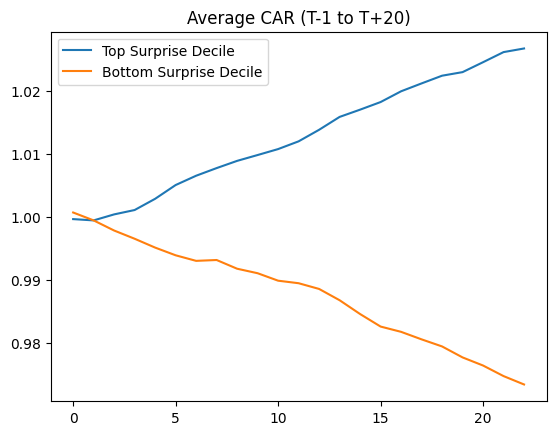

In [102]:
plt.figure()
if top_car is not None: plt.plot(top_car, label="Top Surprise Decile")
if bot_car is not None: plt.plot(bot_car, label="Bottom Surprise Decile")
plt.title("Average CAR (T-1 to T+20)"); plt.legend(); plt.show()

In [ ]:
# === TODO 5: ADV proxy filter and rerun ===
# adv = ... ; filter = adv > threshold ; recompute

In [ ]:
# compute adv proxy by using rolling vol
prices = ret['ret_adj'].unstack().fillna(0)
adv_proxy = prices.rolling(20).std().rank(axis=1, pct=True)

In [ ]:
# get daily universe cutoff for the bottom 20% rolling vol
cut = adv_proxy.apply(lambda r: r.quantile(0.2), axis=1)

In [ ]:
# get days when the stock is liquid measured by higher vol than the bottom 20% cutoff
liquid_days = adv_proxy.gt(cut, axis=0)

In [ ]:
# mask the events df for only the events when the stock is liquid on the day
mask = []
for _, row in events.iterrows():
    d, t = row["date"], row["ticker"]
    if t in liquid_days.columns and d in liquid_days.index and bool(liquid_days.loc[d, t]):
        mask.append(True)
    else:
        mask.append(False)

In [132]:
events_liq = events.loc[mask]

In [134]:
top_car2 = average_car(events_liq[events_liq["decile"]==9])
bot_car2 = average_car(events_liq[events_liq["decile"]==0])

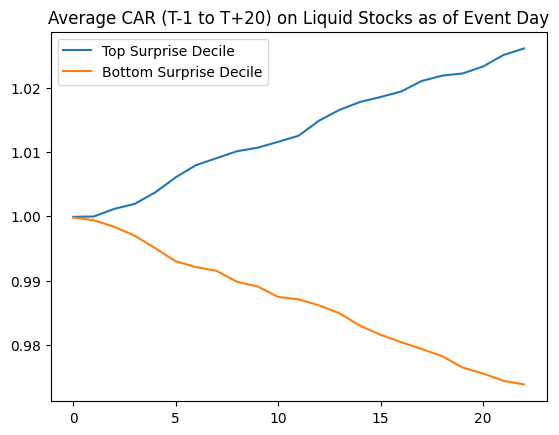

In [135]:
plt.figure()
if top_car2 is not None: plt.plot(top_car2, label="Top Surprise Decile")
if bot_car2 is not None: plt.plot(bot_car2, label="Bottom Surprise Decile")
plt.title("Average CAR (T-1 to T+20) on Liquid Stocks as of Event Day"); plt.legend(); plt.show()